In [120]:
# KORA_S3S4 Data Analysis - Minimum Model

import numpy as np
import pandas as pd
import os
import pandas_profiling as pp
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
import shap
import xgboost
from pygam import GAM, s,f

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Loading the data and data splitting

In [121]:

KORA_Noise_noMissing = pd.read_csv('C:\\Users\\sahar.behzadi\\Desktop\\Noise2Nako\\Data\\KORA_S3_S4\\KORA_Noise_noMissing_median.csv')

In [122]:
# Inputs

X = KORA_Noise_noMissing.drop(['hyper_p', 'bp_diast', 'bp_syst'], axis = 1)
X_mini = KORA_Noise_noMissing[['sex', 'age', 'bmi', 'smoking', 'lden_org']]

# noise cut-off
X_mini_test = X_mini['lden_org']
X_mini_test[X_mini_test<=40] = 40
X_mini['lden_org'] = X_mini_test

X_mini_100 = shap.utils.sample(X_mini, 100) # 100 instances for use as the background distribution
print('Data description \n')
print('Sex: Female = 0, Male = 1 \n Smoking: Current = 1, Ex-smoker = 2, Never smoker =3 \n ')
X_mini['smoking'] = X_mini['smoking']-1
print(X_mini.head())

# Output

Y_hyper = KORA_Noise_noMissing['hyper_p'].astype(int)
Y_SBP = KORA_Noise_noMissing['bp_syst']
Y_DBP = KORA_Noise_noMissing['bp_diast']

Data description 

Sex: Female = 0, Male = 1 
 Smoking: Current = 1, Ex-smoker = 2, Never smoker =3 
 
   sex   age    bmi  smoking  lden_org
0  0.0  31.0  18.94      1.0      41.0
1  1.0  40.0  27.14      1.0      55.2
2  1.0  59.0  30.34      2.0      55.2
3  0.0  62.0  19.46      0.0      46.8
4  0.0  62.0  31.25      1.0      51.2


## Building Models

In [123]:
shap.initjs()

# XGBoost
XGBoost_model = xgboost.XGBRegressor().fit(X_mini, Y_SBP)

# Random Forest (RF)
RF_model = RandomForestRegressor(n_estimators= 10, max_depth= 10, random_state= 0,
                                 max_features='sqrt').fit(X_mini, Y_SBP)

# Linear Regression (LR)
LR_model = linear_model.LinearRegression().fit(X_mini, Y_SBP)

# Generalized Additive Models (GAM)
GAM_model = GAM(f(0)+s(1)+s(2)+f(3)+s(4)).fit(X_mini, Y_SBP)

In [83]:
# explain the model's predictions using SHAP

# XGBoost
XGBoost_explainer = shap.Explainer(XGBoost_model)
XGBoost_shap_values = XGBoost_explainer(X_mini)

# Random Forest
RF_explainer = shap.Explainer(RF_model)
RF_shap_values = RF_explainer(X_mini)

# Linear Regression
LR_explainer = shap.explainers.Linear(LR_model, X_mini)
LR_shap_values = LR_exapliner(X_mini)

# GAM
GAM_explainer = shap.explainers.Additive(GAM_model.predict, X_mini)
GAM_shap_values = GAM_explainer(X_mini)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
Additive explainer: 9117it [00:31, 184.26it/s]                          


In [85]:
# comparing the prediction's explanation for individuals

ind = 1

print('Random Forest')
shap.plots.force(RF_shap_values[ind])

Random Forest


In [86]:
print('XGBoost')
shap.plots.force(XGBoost_shap_values[ind])

XGBoost


In [87]:
print('Linear Regression')
shap.plots.force(LR_shap_values[ind])

Linear Regression


In [88]:
print('GAM')
shap.plots.force(GAM_shap_values[ind])

GAM


In [89]:
#observations = X_mini.to_numpy()
#shap.initjs() 
#shap.force_plot(explainer.expected_value, explainer.shap_values(X_mini),  feature_names=X_mini.columns)

In [90]:
# since the algorithm is somehow too slow for the original data we consider a sample and the following plots are for
# a sample data including 100 samples

observations_sample = X_mini.sample(100, random_state=42)
observations = observations_sample.to_numpy()
Y_SBP_sample = Y_SBP[observations_sample.index]
X_mini_100 = X_mini.iloc[observations_sample.index]
shap.initjs() 

In [91]:
print('Random Forest')
shap.force_plot(RF_explainer.expected_value, RF_explainer.shap_values(observations), features=observations,
                feature_names=X_mini.columns)

Random Forest


In [92]:
print('XGBoost')
shap.force_plot(XGBoost_explainer.expected_value, XGBoost_explainer.shap_values(observations), features=observations,
                feature_names=X_mini.columns)

XGBoost


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [93]:
print('Linear Regression')
shap.force_plot(LR_explainer.expected_value, LR_exapliner.shap_values(observations), features=observations,
                feature_names=X_mini.columns)

Linear Regression


In [94]:
print('GAM')
shap.force_plot(GAM_shap_values.base_values[0], GAM_explainer(X_mini_100).values, features=observations,
                feature_names=X_mini.columns)

GAM


Random Forest


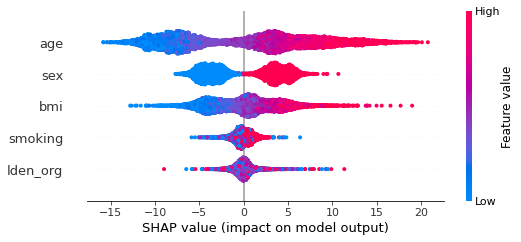

In [95]:
# for the entire dataset
print('Random Forest')
shap.summary_plot(RF_explainer.shap_values(X_mini), features=X_mini, feature_names=X_mini.columns)

XGBoost


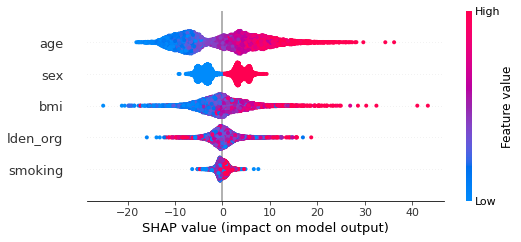

In [96]:
# for the entire dataset
print('XGBoost')
shap.summary_plot(XGBoost_explainer.shap_values(X_mini), features=X_mini, feature_names=X_mini.columns)

Linear Regression


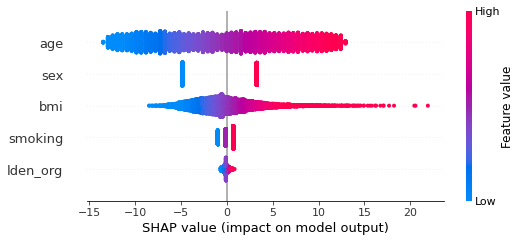

In [97]:
print('Linear Regression')
shap.summary_plot(LR_exapliner.shap_values(X_mini), features=X_mini, feature_names=X_mini.columns)

GAM


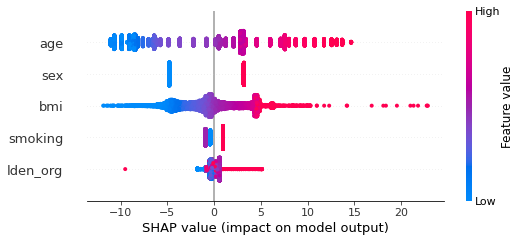

In [98]:
print('GAM')
shap.summary_plot(GAM_shap_values.values, features=X_mini, feature_names=X_mini.columns)

XGBoost


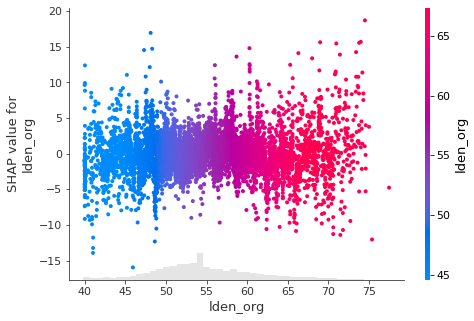

In [99]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
print('XGBoost')
shap.plots.scatter(XGBoost_shap_values[:,"lden_org"], x_jitter=0.5, color = XGBoost_shap_values[:, 'lden_org'])

GAM


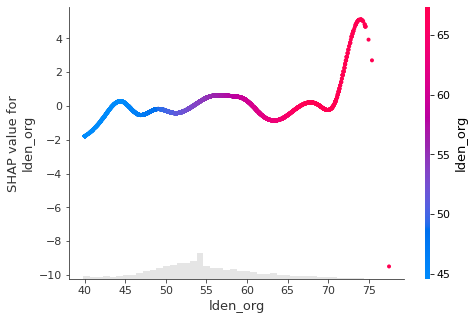

In [100]:
print('GAM')
shap.plots.scatter(GAM_shap_values[:,"lden_org"], x_jitter=0.5, color = GAM_shap_values[:, 'lden_org'])

XGBoost


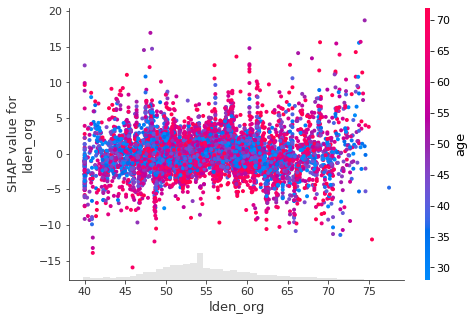

In [101]:
print('XGBoost')
shap.plots.scatter(XGBoost_shap_values[:,"lden_org"], color = XGBoost_shap_values[:, 'age'])

GAM


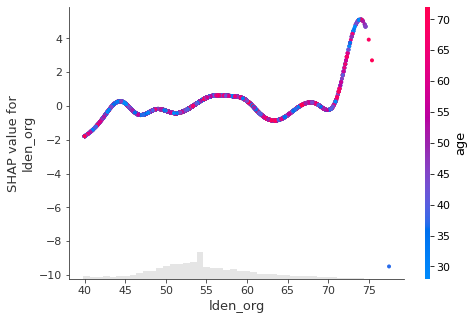

In [102]:
print('GAM')
shap.plots.scatter(GAM_shap_values[:,"lden_org"], color = GAM_shap_values[:, 'age'])

XGBoost


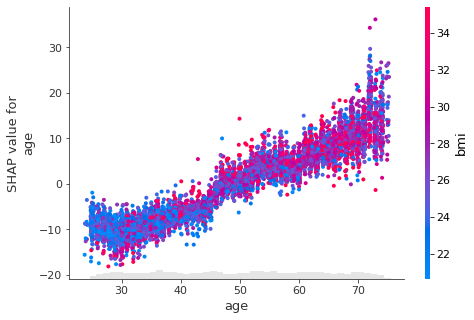

In [103]:
print('XGBoost')
shap.plots.scatter(XGBoost_shap_values[:,"age"], x_jitter=0.5, color = XGBoost_shap_values[:, 'bmi'])

XGBoost


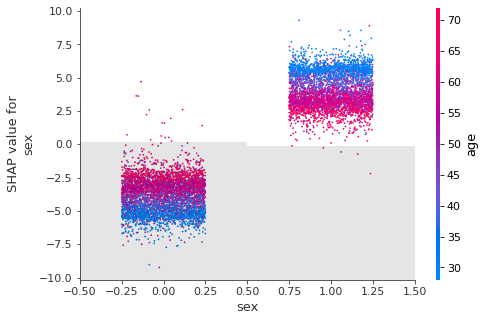

In [104]:
print('XGBoost')
shap.plots.scatter(XGBoost_shap_values[:,"sex"], dot_size = 3 ,x_jitter=0.5, color = XGBoost_shap_values[:, 'age'])

XGBoost


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


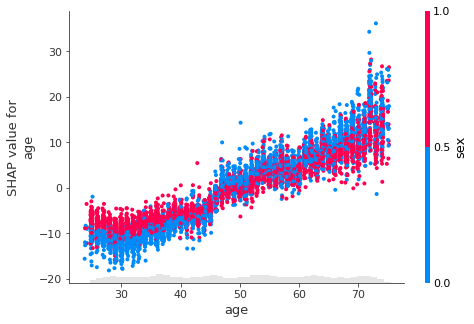

In [105]:
print('XGBoost')
shap.plots.scatter(XGBoost_shap_values[:,"age"], x_jitter=0.4, color = XGBoost_shap_values[:, 'sex'])

### global measure of feature importance

Random Forest


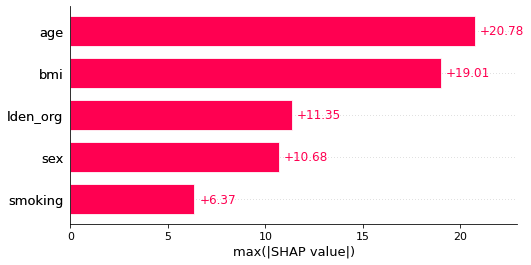

In [106]:
#  max absolute value of shap values for every feature
print('Random Forest')
shap.plots.bar(RF_shap_values.abs.max(0))

XGBoost


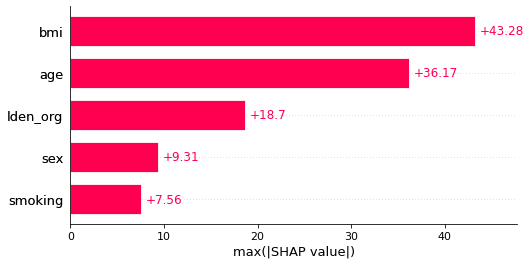

In [107]:
#  max absolute value of shap values for every feature
print('XGBoost')
shap.plots.bar(XGBoost_shap_values.abs.max(0))

Linear Regression


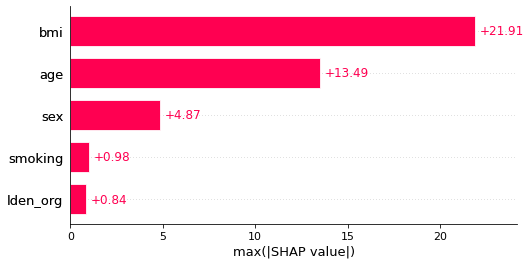

In [108]:
print('Linear Regression')
shap.plots.bar(LR_shap_values.abs.max(0))

GAM


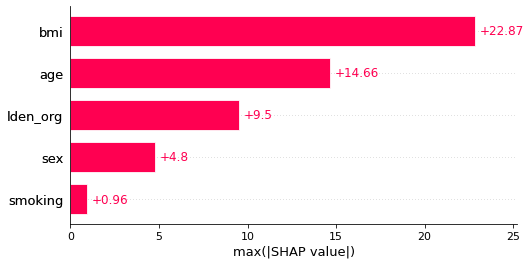

In [109]:
print('GAM')
shap.plots.bar(GAM_shap_values.abs.max(0))

GAM


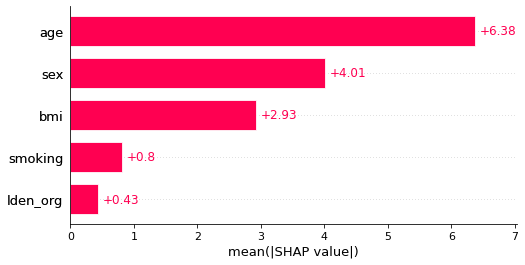

In [111]:
# general feature importance
print('GAM')
shap.plots.bar(GAM_shap_values)

In [112]:
print("Model coefficients:\n")
for i in range(len(LR_model.coef_)):
    print(X_mini.columns[i], "=", LR_model.coef_[i].round(4))
    
X_mini['bmi'].mean()

Model coefficients:

sex = 8.1112
age = 0.5181
bmi = 0.74
smoking = 0.847
lden_org = 0.0414


27.11508227292659

Random Forest


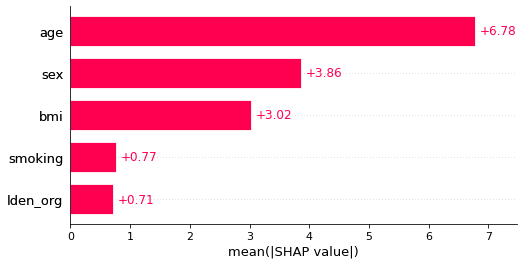

In [113]:
# ploting the mean absolute value for each feature --- 
print('Random Forest')
shap.plots.bar(RF_shap_values)

XGBoost


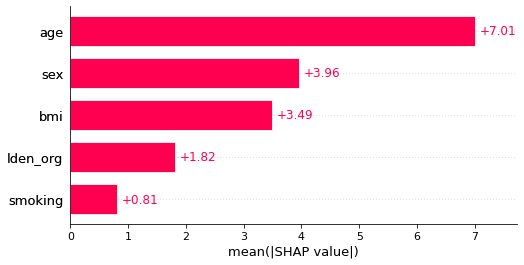

In [114]:
print('XGBoost')
shap.plots.bar(XGBoost_shap_values)

Random Forest


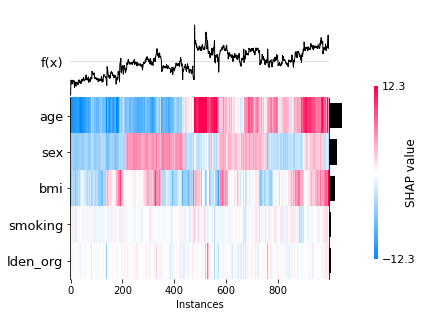

In [43]:
print('Random Forest')
shap.plots.heatmap(RF_shap_values[:1000])

XGBoost


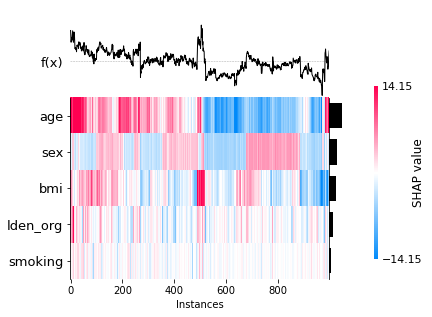

In [44]:
print('XGBoost')
shap.plots.heatmap(XGBoost_shap_values[:1000])

Linear Regression


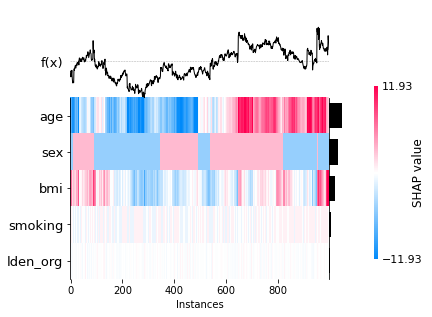

In [82]:
print('Linear Regression')
shap.plots.heatmap(LR_shap_values[:1000])

GAM


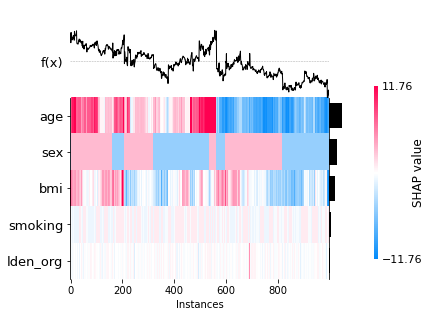

In [84]:
print('GAM')
shap.plots.heatmap(GAM_shap_values[:1000])